4. **_Hypothesis_**:  
   Some users are more likely to badly rate a book, especially the unknowns
   - **Metric**: Rating score

- **Missing Values**:

  - `profileName`: set missing values as unknown
  - `review/score`: remove the entire sample

- **Data Transformation**:

  ***


In [2]:
# Import libraries

import pymongo
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f_oneway

In [3]:
# Connect to MongoDB

client = pymongo.MongoClient('mongodb://localhost:27017/')
database = client['spark_db']
books = database['books_joined']

### Get data from MongoDB


In [4]:
# Define the aggregation pipeline
pipeline = [
    {
        "$project": {
            "profileName": {
                "$ifNull": ["$profileName", "Anonymous"]
            },
            "review/score": 1
        }
    },
    {'$match': {
        'review/score': {'$exists': True, '$ne': 0.0},
    }
    }
]

# Execute the aggregation query and create a DataFrame
source_df = pd.DataFrame(list(books.aggregate(pipeline)))
source_df = source_df.drop('_id', axis=1)


### Prepare the DataFrame for the analysis


In [26]:
user_stats = source_df.groupby('profileName').mean()


user_stats['Std_review_score'] = source_df.groupby('profileName').std()
user_stats['N_reviews'] = source_df['profileName'].value_counts()
user_stats = user_stats.sort_values(by='review/score', ascending=False)
user_stats.reset_index(inplace=True)
user_stats = user_stats[user_stats['profileName'] != 'Anonymous']

user_stats.columns = ['profileName',
                      'Mean_review/score', 'Std_review_score', 'N_reviews']

user_stats = user_stats[user_stats['N_reviews'] >= 10]
user_stats = user_stats.sort_values(by='Std_review_score', ascending=False)
len(user_stats)

1640

### Visualize the data

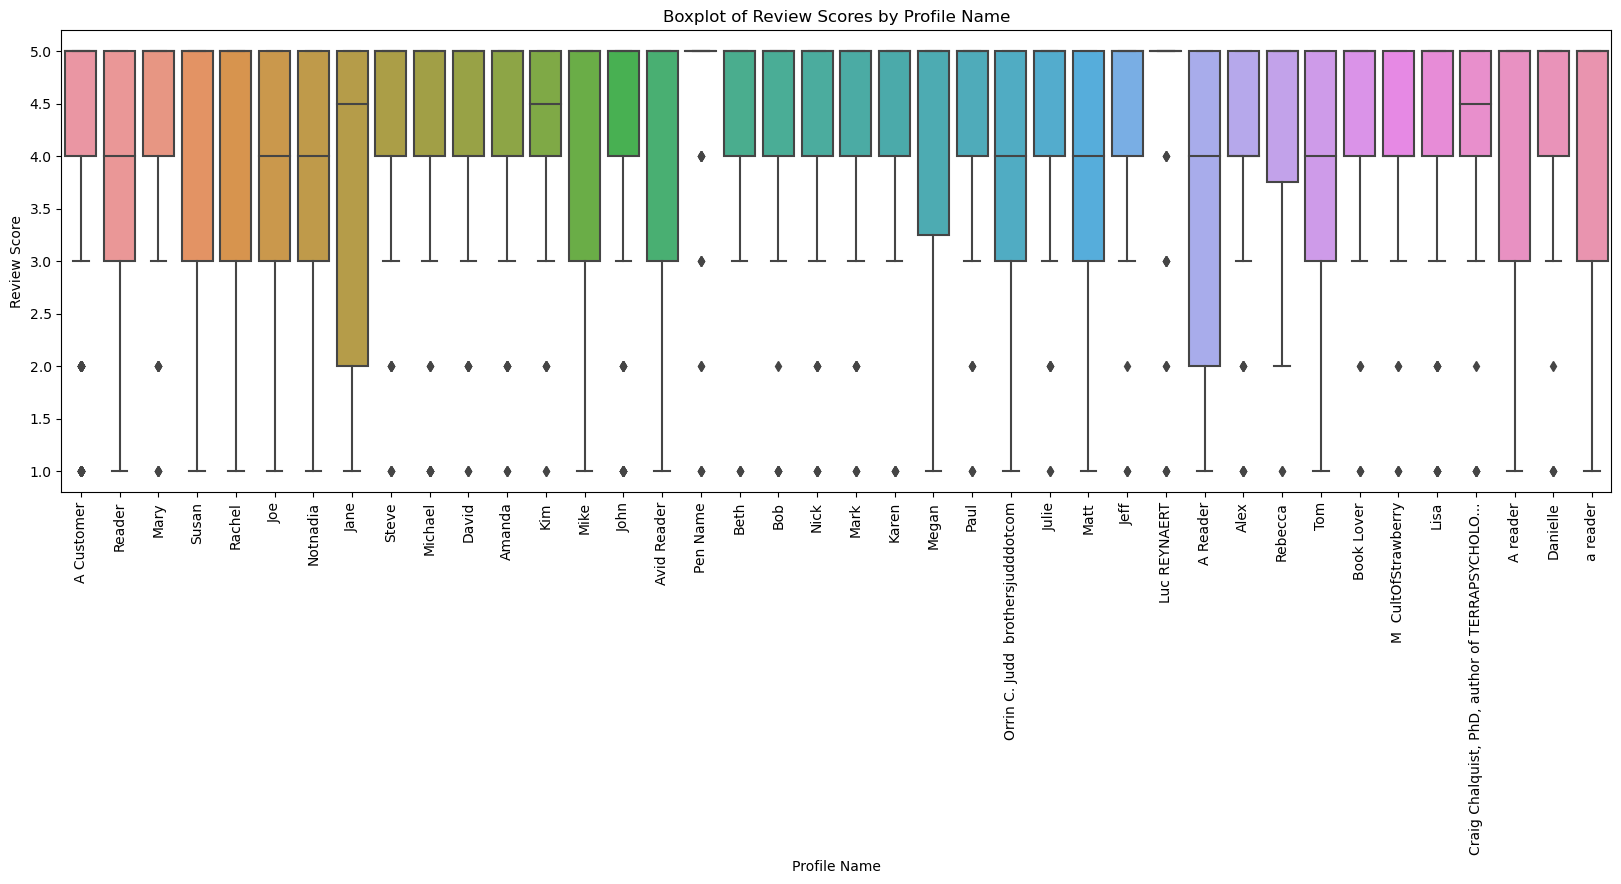

In [18]:
subsample_stat = user_stats.head(40)
df_to_show = source_df.merge(subsample_stat, on='profileName', how='inner')
df_to_show = df_to_show[['profileName', 'review/score']]

# Create a boxplot
plt.figure(figsize=(20, 6))
sns.boxplot(x='profileName', y='review/score', data=df_to_show)
plt.title('Boxplot of Review Scores by Profile Name')
plt.ylabel('Review Score')
plt.xlabel('Profile Name')
plt.xticks(rotation=90)

# Show the plot
plt.show()

### Perform one-way ANOVA.

The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean.  
The groups are the profileNames.  
Results of the test :
- F-statistic (F-statistic):
  The F-statistic is a test statistic generated by the ANOVA test. It measures the ratio of the variation between group means to the variation within the groups.
  A larger F-statistic indicates a greater difference in means among the groups relative to the variation within the groups.
  In the context of ANOVA, a larger F-statistic is more likely to lead to the rejection of the null hypothesis, suggesting that there are significant differences among the groups.

  
- P-value (p_value):
  The p-value is a measure of the evidence against the null hypothesis (H0) in statistical hypothesis testing.
  It represents the probability of observing the results (or more extreme results) if the null hypothesis were true.
  In the context of ANOVA, a small p-value (typically less than your chosen significance level, e.g., 0.05) suggests that the differences in means among the groups are statistically significant.
  Conversely, a large p-value suggests that the observed differences could have occurred by random chance, and you fail to reject the null hypothesis.

In [27]:
subset_df = source_df.merge(subsample_stat, on='profileName', how='inner')
subset_df = subset_df[['profileName', 'review/score']]

# Group scores by user
user_groups = [subset_df['review/score'][subset_df['profileName'] == user] for user in subset_df['profileName'].unique()]

# Perform ANOVA
f_statistic, p_value = f_oneway(*user_groups)

print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")

F-statistic: 1.737298743424843
P-value: 0.0031433731742704805


## Conclusion
Since the F-statistic is high and p-value is extremely low, whe can reject the H0 hypothesis, so the rating score is influenced by the user

----


### Now let's analyze if the anonymous users give lower rating score 